Reference here: [Pysal Documentation](https://buildmedia.readthedocs.org/media/pdf/pysal/latest/pysal.pdf)

In [1]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

import pass_kp

In [2]:
import geopandas as gpd
import pysal.lib
import matplotlib.pyplot as plt

/home/kpark/.conda/envs/yeah/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [132]:
!wget -O 'subway_line.geojson' 'https://data.cityofnewyork.us/api/geospatial/3qz8-muuu?method=export&format=GeoJSON'

--2019-07-22 17:54:35--  https://data.cityofnewyork.us/api/geospatial/3qz8-muuu?method=export&format=GeoJSON
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.geo+json]
Saving to: ‘subway_line.geojson’

subway_line.geojson     [ <=>                ] 618.32K  --.-KB/s    in 0.1s    

2019-07-22 17:54:35 (6.02 MB/s) - ‘subway_line.geojson’ saved [633163]



In [3]:
# Week
sql = "select pulocationid, dolocationid, count (*) \
    from taxi_large \
    where sr_flag = '1' and date_part('hour', pickup_datetime) between '{}' and '{}' and date_part('dow', pickup_datetime) in ('1','2','3','4','5') \
    group by pulocationid, dolocationid;".format('06', '22')

dat = sqlio.read_sql_query(sql, pass_kp.conn)

In [4]:
dat = dat.dropna()
dat.pulocationid = dat.pulocationid.astype(int)
dat.dolocationid = dat.dolocationid.astype(int)

In [5]:
dat = dat.rename(columns = {'count': 'cnt'})

In [64]:
df = gpd.read_file('geo_export_8d68d6ca-e91d-4551-8320-9372ebc22903.shp', geometry='geometry')
w = pysal.lib.weights.contiguity.Queen.from_dataframe(df)

/home/kpark/.conda/envs/yeah/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 6 disconnected observations 
  Island ids: 0, 42, 103, 104, 105, 205
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [7]:
df.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,(POLYGON ((-73.82337597260663 40.6389870471767...
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,POLYGON ((-73.84792614099985 40.87134223399991...
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,POLYGON ((-73.97177410965318 40.72582128133706...
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17421738099989 40.5625680859999,..."


In [8]:
tmp = dat.merge(df.reset_index(), left_on='pulocationid', right_on='location_i')[['pulocationid','dolocationid','cnt','index']]
tmp = tmp.rename(columns={'index': 'pu_idx'})
tmp = tmp.merge(df.reset_index(), left_on='dolocationid', right_on='location_i')[['pulocationid','dolocationid','cnt','pu_idx','index']]
tmp = tmp.rename(columns={'index' : 'do_idx'})

In [65]:
df['location_i'] = df['location_i'].astype(int)

In [10]:
# print(w.islands)

for i in range(len(w.neighbors)):
    w.neighbors[i].sort()

In [40]:
routes = []
for numnum in range(263):
    try:
        hi = numnum
        hi2 = hi 
        route = []
        bye_list = []
        for i in range(8):
            init_zone = hi # index
            df2 = df.query('index in @w.neighbors[{}]'.format(init_zone))
            index_id = df2.index.to_list()
            result = tmp.query('pu_idx == @init_zone and do_idx in @index_id')
            result = result.reset_index(drop=True)

            # Consdier internal trips
            dfs1 = []
            dfs2 = []
            for j in range(len(result)):
                dfs1.append(tmp.query('pu_idx == @result\
                .pu_idx[{0}] and do_idx\
                == @result.pu_idx[{0}]'.format(j)))
                dfs2.append(tmp.query('pu_idx == @result\
                .do_idx[{0}] and do_idx\
                == @result.do_idx[{0}]'.format(j)))
            result.cnt = result.cnt.add(pd.concat(dfs2). \
                                        reset_index(drop=True). \
                                        cnt, fill_value=0). \
            add(pd.concat(dfs1).reset_index(drop=True).cnt,fill_value=0)

            # Find index from locationid again for next loop
            result = result.query('do_idx not in @bye_list')
            bye = result.loc[result['cnt'].idxmax()].do_idx
            bye_list.append(bye)
            hi = df.query('index == {}'.format(bye)).index[0]
            route.append(hi)
        route = [hi2] + route
        routes.append(route)
    except:
        pass

In [41]:
routes_ = routes.copy()

In [42]:
for i in range(len(routes)):
    yo = tmp.query('pu_idx in @route and do_idx in @routes[{}]'.format(i))
    yo = yo[['pu_idx','do_idx','cnt']]
    routes[i] += [yo.cnt.sum()]

In [49]:
table_ = pd.DataFrame(routes, columns=['origin','stop1','stop2','stop3','stop4','stop5','stop6','stop7','dest','trips'])

In [75]:
table_ = table_.sort_values('trips', ascending=False)

In [72]:
table_ = table_.merge(df.reset_index(), left_on='origin', right_on='index').drop(['index','location_i','objectid','shape_area','shape_leng','zone','geometry'],axis=1)

In [81]:
table_.query('borough not in ["Manhattan", "Staten Island", "Bronx"]')

,origin,stop1,stop2,stop3,stop4,stop5,stop6,stop7,dest,trips,borough
141,55,84,130,225,6,222,148,192,176,35376,Queens
140,194,84,130,225,6,222,148,192,176,35126,Queens
139,157,84,130,225,6,222,148,192,176,34966,Queens
138,159,84,130,225,6,222,148,192,176,34838,Queens
137,130,84,130,225,6,222,148,192,176,34398,Queens
136,95,194,84,130,225,6,222,148,192,33163,Queens
135,148,222,6,225,130,84,55,95,194,32425,Queens
134,93,95,194,84,130,225,6,222,148,31988,Queens
133,131,95,194,84,130,225,6,222,148,31824,Queens
132,145,130,84,55,95,194,159,198,35,28355,Queens


In [131]:
table_.query('borough in ["Queens"]')[:10]

,origin,stop1,stop2,stop3,stop4,stop5,stop6,stop7,dest,trips,borough
141,55,84,130,225,6,222,148,192,176,35376,Queens
140,194,84,130,225,6,222,148,192,176,35126,Queens
139,157,84,130,225,6,222,148,192,176,34966,Queens
138,159,84,130,225,6,222,148,192,176,34838,Queens
137,130,84,130,225,6,222,148,192,176,34398,Queens
136,95,194,84,130,225,6,222,148,192,33163,Queens
135,148,222,6,225,130,84,55,95,194,32425,Queens
134,93,95,194,84,130,225,6,222,148,31988,Queens
133,131,95,194,84,130,225,6,222,148,31824,Queens
132,145,130,84,55,95,194,159,198,35,28355,Queens


In [92]:
ref = tmp[['pulocationid','pu_idx']].drop_duplicates()

In [25]:
# yo.groupby(['pu_idx','do_idx']).sum().unstack(fill_value=0)

In [94]:
ref.head()

,pulocationid,pu_idx
0,1,0
1,10,10
2,100,100
3,101,101
4,102,102


In [97]:
df = df.merge(ref, left_on='location_i', right_on='pulocationid')

In [137]:
subway_line = gpd.read_file('subway_line.geojson')

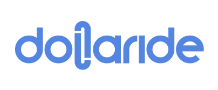

- Dollaride Color is #0497EA

In [203]:
a = table_.origin.unique()
a.sort()

In [ ]:
# Saving every routes
%%capture
for i in range(len(routes)):
    df3 = df.query('pu_idx in @routes[{}]'.format(i))

    fig, ax = plt.subplots(1, figsize=(20, 20))
    subway_line.plot(ax=ax, color='#f5b164', linewidth=1.8)
    df.plot(ax=ax, facecolor='whitesmoke', edgecolor='grey', linestyles='--', alpha=1);
    df3.plot(ax=ax, facecolor='#0497EA', alpha=0.7, edgecolor='grey', linewidth=2);

    df.query('borough in ["Manhattan", "Staten Island", "Bronx", "EWR"]').plot(ax=ax, facecolor='white');
    # for x, y, label in zip(df3.geometry.centroid.x, df3.geometry.centroid.y, df3.index.to_list()):
    #     ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords="offset points", color = "gold")
    plt.axis('off');
    plt.savefig('route{}.png'.format(routes[i][0]));

In [248]:
# Route cannot be duplicated
# The number of check is 6
table_['check1'] = table_.stop1.astype(str) + table_.stop2.astype(str) + table_.stop3.astype(str)
table_['check2'] = table_.stop2.astype(str) + table_.stop3.astype(str) + table_.stop4.astype(str)
table_['check3'] = table_.stop3.astype(str) + table_.stop4.astype(str) + table_.stop5.astype(str)
table_['check4'] = table_.stop4.astype(str) + table_.stop5.astype(str) + table_.stop6.astype(str)
table_['check5'] = table_.stop5.astype(str) + table_.stop6.astype(str) + table_.stop7.astype(str)
table_['check6'] = table_.stop6.astype(str) + table_.stop7.astype(str) + table_.dest.astype(str)

In [242]:
# table_ = table_.drop(['check1','check2','check3','check3','check4','check5','check6'], axis=1)

In [255]:
table_2 = table_.query('borough not in ["Manhattan", "Staten Island", "Bronx"]').drop_duplicates(subset=['check1'])
table_2 = table_2.query('borough not in ["Manhattan", "Staten Island", "Bronx"]').drop_duplicates(subset=['check2'])
table_2 = table_2.query('borough not in ["Manhattan", "Staten Island", "Bronx"]').drop_duplicates(subset=['check3'])
table_2 = table_2.query('borough not in ["Manhattan", "Staten Island", "Bronx"]').drop_duplicates(subset=['check4'])
table_2 = table_2.query('borough not in ["Manhattan", "Staten Island", "Bronx"]').drop_duplicates(subset=['check5'])
table_2 = table_2.query('borough not in ["Manhattan", "Staten Island", "Bronx"]').drop_duplicates(subset=['check6'])
display(table_2)

,origin,stop1,stop2,stop3,stop4,stop5,stop6,stop7,dest,trips,borough,check1,check2,check3,check4,check5,check6
141,55,84,130,225,6,222,148,192,176,35376,Queens,84130225,1302256,2256222,6222148,222148192,148192176
136,95,194,84,130,225,6,222,148,192,33163,Queens,19484130,84130225,1302256,2256222,6222148,222148192
135,148,222,6,225,130,84,55,95,194,32425,Queens,2226225,6225130,22513084,1308455,845595,5595194
134,93,95,194,84,130,225,6,222,148,31988,Queens,9519484,19484130,84130225,1302256,2256222,6222148
132,145,130,84,55,95,194,159,198,35,28355,Queens,1308455,845595,5595194,95194159,194159198,15919835
131,222,6,225,130,84,55,95,194,159,27759,Queens,6225130,22513084,1308455,845595,5595194,95194159
126,112,257,112,74,36,219,60,21,48,15856,Brooklyn,25711274,1127436,7436219,3621960,2196021,602148
124,258,74,36,219,60,21,48,97,180,15596,Brooklyn,7436219,3621960,2196021,602148,214897,4897180
121,28,15,180,97,48,60,219,36,35,14290,Brooklyn,1518097,1809748,974860,4860219,6021936,2193635
120,15,180,97,48,60,219,36,35,198,14242,Brooklyn,1809748,974860,4860219,6021936,2193635,3635198


In [256]:
table_2 = table_2[:20]

In [322]:
table_2

,origin,stop1,stop2,stop3,stop4,stop5,stop6,stop7,dest,trips,borough,check1,check2,check3,check4,check5,check6
141,55,84,130,225,6,222,148,192,176,35376,Queens,84130225,1302256,2256222,6222148,222148192,148192176
136,95,194,84,130,225,6,222,148,192,33163,Queens,19484130,84130225,1302256,2256222,6222148,222148192
135,148,222,6,225,130,84,55,95,194,32425,Queens,2226225,6225130,22513084,1308455,845595,5595194
134,93,95,194,84,130,225,6,222,148,31988,Queens,9519484,19484130,84130225,1302256,2256222,6222148
132,145,130,84,55,95,194,159,198,35,28355,Queens,1308455,845595,5595194,95194159,194159198,15919835
131,222,6,225,130,84,55,95,194,159,27759,Queens,6225130,22513084,1308455,845595,5595194,95194159
126,112,257,112,74,36,219,60,21,48,15856,Brooklyn,25711274,1127436,7436219,3621960,2196021,602148
124,258,74,36,219,60,21,48,97,180,15596,Brooklyn,7436219,3621960,2196021,602148,214897,4897180
121,28,15,180,97,48,60,219,36,35,14290,Brooklyn,1518097,1809748,974860,4860219,6021936,2193635
120,15,180,97,48,60,219,36,35,198,14242,Brooklyn,1809748,974860,4860219,6021936,2193635,3635198


In [258]:
import os

In [286]:
%%capture
for i in range(len(table_)):
    df3 = df.query('pu_idx in @table_2.iloc[{}].to_list()'.format(i))

    fig, ax = plt.subplots(1, figsize=(20, 20))
    subway_line.plot(ax=ax, color='#f5b164', linewidth=1.8)
    df.plot(ax=ax, facecolor='whitesmoke', edgecolor='grey', linestyles='--', alpha=1);
    df3.plot(ax=ax, facecolor='#0497EA', alpha=0.7, edgecolor='grey', linewidth=2);

    df.query('borough in ["Manhattan", "Staten Island", "Bronx", "EWR"]').plot(ax=ax, facecolor='white');
    # for x, y, label in zip(df3.geometry.centroid.x, df3.geometry.centroid.y, df3.index.to_list()):
    #     ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords="offset points", color = "gold")
    plt.axis('off');
    if os.path.isdir('routes_map') == False:
        os.mkdir('routes_map')
    plt.savefig('routes_map/route{}.png'.format(table_2.iloc[i].to_list()[0]), bbox_inches='tight');    

IndexError: single positional indexer is out-of-bounds

In [287]:
from glob import glob
import matplotlib.image as im

In [319]:
glob('routes_map/*.png')

['routes_map/route15.png',
 'routes_map/route112.png',
 'routes_map/route148.png',
 'routes_map/route28.png',
 'routes_map/route196.png',
 'routes_map/route136.png',
 'routes_map/route52.png',
 'routes_map/route64.png',
 'routes_map/route56.png',
 'routes_map/route145.png',
 'routes_map/route93.png',
 'routes_map/route53.png',
 'routes_map/route21.png',
 'routes_map/route55.png',
 'routes_map/route74.png',
 'routes_map/route222.png',
 'routes_map/route216.png',
 'routes_map/route102.png',
 'routes_map/route95.png',
 'routes_map/route258.png']

In [323]:
# Zone 개수는 상관없이, Tree 제시

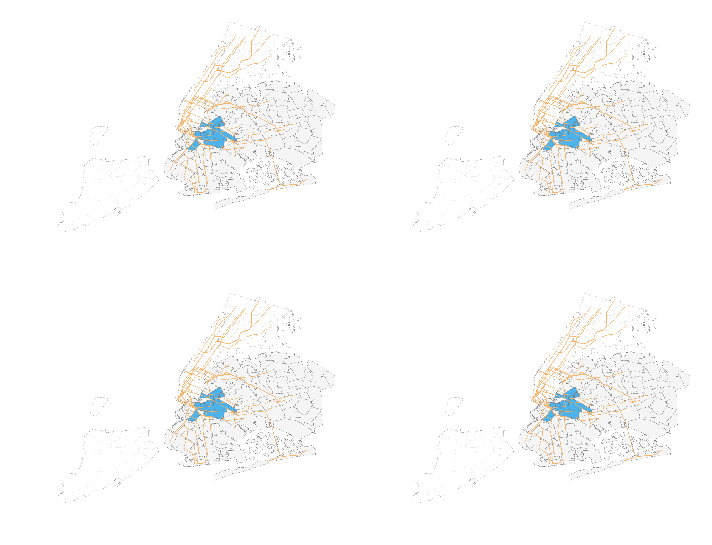

In [321]:
f, ax = plt.subplots(2, 2, figsize=(10,10))
for i in [0,1]:
    for j in [0,1]:
        ax[i][j].imshow(im.imread(glob('routes_map/*.png')[0]));
        ax[i][j].axis('off');
        plt.tight_layout()

In [ ]:
ax[0][0].imshow(im.imread(glob('routes_map/*.png')[0]));
ax[0][0].axis('off');
plt.tight_layout()